# Crossmatch com o catálogo do TESS

---

Este notebook mostra como foi feito o crossmatch entre os dados do Kepler e K2 com o TESS para identificar quais estrelas dos dois primeiros catálogos que possuem exoplanetas detectados, tem observações feitas pelo TESS.

- João Aires (UFRN)
- Leonardo Andrade de Almeida (ECT/UFRN)

## 0. Bibliotecas e estilo de plot

### 0.1 Bibliotecas

Para realizar os procedimentos aqui mostrados, além das bibliotecas básicas como ```numpy``` e ```matplotlib```, iremos utilizar:

- ```KeplerK2TessQuery```: Para fazer o download dos exoplanetas detectados pelo Kepler, K2 e TESS;
- ```astropy```: Para tratar com tabelas, escrita e leitura de arquivos, coordenadas astronômicas e unidades;
- ```astroquery```: Para fazer o crossmatch com o __[catálogo do TESS](https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=IV/38)__.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from KeplerK2TessQuery import download_kepler_k2_tess
from astropy.io import ascii
from astropy import table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.xmatch import XMatch

### 0.2 Estilo do plot

In [38]:
def style():
    plt.rc("lines", linewidth=1.0, linestyle="-", color="white")
    plt.rc("font", family="sans-serif", weight="normal", size=11.0)
    plt.rc(
        "axes",
        edgecolor="black",
        facecolor="white",
        linewidth=1.0,
        grid=False,
        titlesize=14,
        labelsize=12,
        labelweight="normal",
        labelcolor="black",
    )
    plt.rc('figure', facecolor='white')
    plt.rc("axes.formatter", limits=(-4, 4))
    plt.rc(("xtick", "ytick"), labelsize=12, direction="in", color='black')
    plt.rc("xtick", top=True)
    plt.rc("ytick", right=True)
    plt.rc(("xtick.major", "ytick.major"), size=4, pad=6, width=1.0)
    plt.rc(("xtick.minor", "ytick.minor"), size=2, pad=6, width=1.0, visible=True)
    plt.rc("legend", numpoints=1, fontsize="x-large", shadow=False, frameon=False)
    
style()

## 1. Download dos dados do Kepler e K2

Nesta parte, utilizamos a função ```download_kepler_k2_tess()``` para acessar remotamente, da base __[NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html)__, os exoplanetas que foram detectados pelo Kepler e K2.

In [42]:
# Exoplanetas observados pelas missões Kepler e K2 (não necessitamos do TESS)
kepler, k2, _ = download_kepler_k2_tess()

Resumo dos dados
(NASA Exoplanet Archive)
-----------------------------------------
Kepler: 		 2778 planetas
K2: 			 548 planetas
TESS: 			 570 planetas
-----------------------------------------
Total: 			 3896 planetas


As tabelas acima possuem as seguintes colunas:

- ```nome_planeta```: Nome do exoplaneta;
- ```nome_estrela```: Nome da estrela hospedeira;
- ```data_publicacao```: Data (YYYY-MM) da publicação dos parâmetros planetários;
- ```ano_deteccao```: Ano de detecção do exoplaneta;
- ```missao```: Missão que detectou o exoplaneta (Kepler, K2 ou TESS);
- ```referencia```: Referência;
- ```ra```: Ascenção reta;
- ```dec```: Declinação;
- ```sky_coord```: String com formado _'ra','dec'_. 

## 2. Crossmatch com o TESS

Nesta parte, utilizamos o módulo ```xmatch``` do ```astroquery``` para relizar o crossmatch entre as tabelas ```kepler``` e ```k2``` e o __[catálogo do TESS](https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=IV/38)__. Como resultado final, salvamos as tabelas com as estrelas que foram observadas pelo TESS nos arquivos (para Kepler e K2, respectivamente):

- ```kepler_tess_exoplanets.dat```
- ```k2_tess_exoplanets.dat```

Nas tabelas acima, adicionamos também as colunas __TIC__ e __angDist__ contendo o identificador no catálogo do TESS e a distância angular (em segundos de arco) entre os alvos nos dois catálogos (Kepler/K2 e TESS) obtidos no crossmatch, respectivamente.

In [47]:
columns = np.append(kepler.colnames, ['TIC', 'angDist'])

kepler_tess = XMatch.query(cat1=kepler, cat2='vizier:IV/38/tic', colRA1='ra', colDec1='dec', max_distance=1*u.arcsec)
kepler_tess = table.unique(kepler_tess.group_by(keys='angDist'), keys='nome_planeta')
kepler_tess.keep_columns(columns)

filename = 'kepler_tess_exoplanets.dat'
ascii.write(kepler_tess, filename, overwrite=True)
print(f'Crossmatch Kepler-TESS salvo em: \t {filename}')


k2_tess     = XMatch.query(cat1=k2, cat2='vizier:IV/38/tic', colRA1='ra', colDec1='dec', max_distance=1*u.arcsec)  
k2_tess     = table.unique(k2_tess.group_by(keys='angDist'), keys='nome_planeta')
k2_tess.keep_columns(columns)

filename = 'k2_tess_exoplanets.dat'
ascii.write(k2_tess, filename, overwrite=True)
print(f'Crossmatch K2-TESS salvo em: \t\t {filename}')


print('')
print('Resultado crossmatch')
print('---------------------------------------')
print(f'Kepler + TESS: \t\t {len(kepler_tess)} planetas')
print(f'K2 + TESS: \t\t {len(k2_tess)} planetas')
print('---------------------------------------')
print(f'Total: \t\t\t {len(kepler_tess) + len(k2_tess)} planetas')

Crossmatch Kepler-TESS salvo em: 	 kepler_tess_exoplanets.dat
Crossmatch K2-TESS salvo em: 		 k2_tess_exoplanets.dat

Resultado crossmatch
---------------------------------------
Kepler + TESS: 		 2745 planetas
K2 + TESS: 		 424 planetas
---------------------------------------
Total: 			 3169 planetas


Caso o leitor deseje obter também os setores em que tais estrelas foram observadas, a célula abaixo pode ser transformada em célula de código. Nela, usamos a função ```get_tess_sectors()```definida em ```tess_sectors.py``` para criar mais duas colunas:

- ```tess_setores```: Contém os setores do TESS que observaram a estrela;
- ```tess_setores_lc```: Contém os setores do TESS que observaram a estrela e produziram curva de luz seguindo o pipeline do instrumento.

```python
from tess_sectors import get_tess_sectors

kepler_tess = get_tess_sectors(kepler_tess, lc=True)
k2_tess     = get_tess_sectors(k2_tess, lc=True)
```

## 3. Plot Mollweide projection for exoplanets

Esta parte faz o plot dos sistemas planetários na __[projeção de Mollweide](https://pt.wikipedia.org/wiki/Proje%C3%A7%C3%A3o_de_Mollweide)__

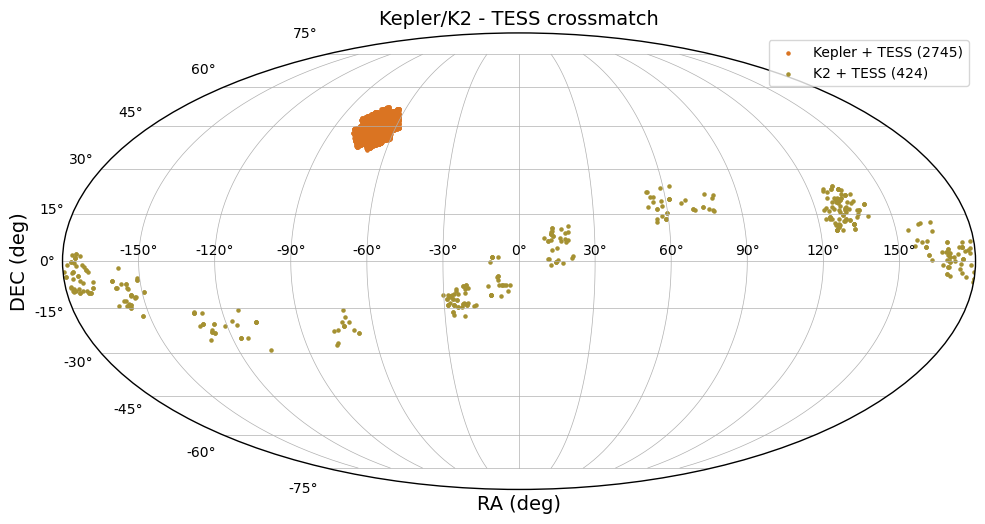

In [64]:
fig = plt.figure(figsize=(10,6))

coords1 = SkyCoord(ra=kepler_tess['ra'], dec=kepler_tess['dec'], unit=(u.deg, u.deg), frame='icrs')
ra_rad1 = coords1.ra.radian  # RA in radians
dec_rad1 = coords1.dec.radian  # DEC in radians

ra_adjusted_deg1 = kepler_tess['ra']
ra_adjusted_deg1[ra_adjusted_deg1 > 180] -= 360
ra_rad1 = np.radians(ra_adjusted_deg1)

coords2 = SkyCoord(ra=k2_tess['ra'], dec=k2_tess['dec'], unit=(u.deg, u.deg), frame='icrs')
ra_rad2 = coords2.ra.radian  # RA in radians
dec_rad2 = coords2.dec.radian  # DEC in radians

ra_adjusted_deg2 = k2_tess['ra']
ra_adjusted_deg2[ra_adjusted_deg2 > 180] -= 360
ra_rad2 = np.radians(ra_adjusted_deg2)


ax = fig.add_subplot(111, projection="mollweide")
ax.grid(True, lw=.5)
ax.scatter(ra_rad1, dec_rad1, s=5, c='#da7422', label=f'Kepler + TESS ({len(kepler_tess)})')
ax.scatter(ra_rad2, dec_rad2, s=5, c='#a59132', label=f'K2 + TESS ({len(k2_tess)})')

ax.set_xticks(np.radians([-150 ,-120, -90, -60, -30, 0, 30, 60, 90, 120, 150]))
ax.set_xticklabels(['-150°', '-120°', '-90°', '-60°', '-30°', '0°', '30°', '60°', '90°', '120°', '150°'], fontsize=10)
ax.set_yticks(np.radians([-75 ,-60, -45, -30, -15, 0, 15, 30, 45, 60, 75]))
ax.set_yticklabels(['-75°', '-60°', '-45°', '-30°', '-15°', '0°', '15°', '30°', '45°', '60°', '75°'], fontsize=10)

ax.set_xlabel('RA (deg)', fontsize=14)
ax.set_ylabel('DEC (deg)', fontsize=14)
ax.set_title('Kepler/K2 - TESS crossmatch')
ax.legend(fontsize=10, frameon=True)

fig.tight_layout()
#plt.savefig('kepler_k2_tess.png', dpi=400)